## Sea turtle face detection using an encoder decoder segmentation architecture and connected components

by Marsh [vbookshelf]<br>
13 Nov 2020



This notebook describes how to use a segmentation approach combined with connected components to detect sea turtle faces. I've used a pre-trained MobileNet encoder combined with a U-Net decoder. This is a simple single model setup without any ensembling or fold averaging. The model was trained on Google Colab for 30 epochs. Training time was approx. 30 seconds per epoch when using a Tesla T4 GPU. 

The model produced a leaderboard IOU score of 0.828. It has a size of approx 27MB. 

It's possible to get a leaderboard score of 0.87 by using larger encoder networks like Densenet161. However, I believe that even though this model's leaderboard score is slighly lower, its small size combined mobilenet's speed makes it a better candidate for use in a production system.

## Connect to your personal Google Drive folders

In [1]:
# Connect to your google drive so that the submission csv file, 
# the trained model and other output files can be
# saved there directly from this notebook.

In [2]:
# Run this cell, follow the Google prompts and copy the generated password.
# Enter the password and then run this cell again.

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [ ]:
# This is the path to use to access the your google drive personal folders
import os

path = '/content/gdrive/My Drive/' + 'path_to_your_drive_folder'

os.listdir(path)

## Download a Kaggle dataset

In [4]:
# This code assumes that the data is stored as a Kaggle dataset.
# Be sure to store Zindi data in a private dataset when using Kaggle.
# The rules don't allow competition data to be shared publicly.

In [5]:
%%capture

# Uninstall and reinstall kaggle

!pip uninstall -y kaggle
!pip install kaggle

In [6]:
# Set environment variables for using the Kaggle API.

# Go to Kaggle.
# Click on account.
# Click the 'Create New API Token' button.
# A .json file will download.
# Open the file with a text editor and
# copy and paste your username and key from that file below.

import os

os.environ["KAGGLE_USERNAME"] = 'your_kaggle_username'
os.environ["KAGGLE_KEY"] = 'your_kaggle_api_key'

In [7]:
# Download the data from your private kaggle dataset.

raw_data_dir = "input/raw"

# Change this line to suit your kaggle account.
# On the kaggle dataset page click the three dots on the right and
# then click copy the API command.
# Example of what will be copied:
# kaggle datasets download -d vbookshelf/zindi-sea-turtles

# Modify the line below using the info you copied.

!kaggle datasets download -d your_kaggle_username/your_dataset_name -p {raw_data_dir}

 93% 121M/130M [00:01<00:00, 43.8MB/s]
100% 130M/130M [00:01<00:00, 70.6MB/s]


In [8]:
# Check that the zip file was downloaded
!ls {raw_data_dir}

zindi-sea-turtles.zip


In [9]:
# Fuze-zip allows us to access zipped folders without
# first unzipping them. This is helpful when working
# with large files.

%%capture

!apt-get install -y fuse-zip

In [10]:
# Apply fuze-zip to the  data
# ----------------------------

%%time

input_dir = "/tmp/kaggle-data"
!mkdir {input_dir}
!fuse-zip input/raw/zindi-sea-turtles.zip {input_dir}

CPU times: user 5.24 ms, sys: 6.93 ms, total: 12.2 ms
Wall time: 223 ms


In [11]:
# Check that everything is working.
!ls {input_dir}

0B6378DA.JPG
IMAGES_512
Local_Ocean_Conservation_Sea_Turtle_Face_Detection_Starter_Notebook.ipynb
SampleSubmission.csv
Train.csv
turtle-images
turtle-masks


In [12]:
path = '/tmp/kaggle-data/'
os.listdir(path)

['0B6378DA.JPG',
 'IMAGES_512',
 'Local_Ocean_Conservation_Sea_Turtle_Face_Detection_Starter_Notebook.ipynb',
 'SampleSubmission.csv',
 'Train.csv',
 'turtle-images',
 'turtle-masks']

In [13]:
# This is how to access the downloaded folders

base_path = '/tmp/kaggle-data/'

os.listdir(base_path)

['0B6378DA.JPG',
 'IMAGES_512',
 'Local_Ocean_Conservation_Sea_Turtle_Face_Detection_Starter_Notebook.ipynb',
 'SampleSubmission.csv',
 'Train.csv',
 'turtle-images',
 'turtle-masks']

## Install Packages

In [14]:
%%capture

# Yes, this is the same NLP transfomers package where Bert lives.

! pip install transformers

In [15]:
%%capture

# There was an error in the latest issue of albumemtations.
# To fix this error I'm using an older version.

! pip install albumentations==0.4.6

In [16]:
# We'll be using the excellent segmentation-models-pytorch package 
# created by Pavel Yakubovsky.
# https://github.com/qubvel/segmentation_models.pytorch

# More info on using this package is available here:
# https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/103367#latest-595453

%%capture

! pip install segmentation-models-pytorch

In [17]:
import pandas as pd
import numpy as np
import os


import cv2
import time
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from torch.utils.data import Dataset, DataLoader

#from tqdm import tqdm

# The usual tqdm doesn't work well in colab.
# This is the solution:
# https://stackoverflow.com/questions/41707229/tqdm-printing-to-newline
import tqdm.notebook as tq
# for i in tq.tqdm(...):

import gc

import albumentations as albu
from albumentations import Compose

from sklearn import model_selection
from sklearn.utils import shuffle
from skimage import measure

import transformers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

import matplotlib.pyplot as plt
%matplotlib inline

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

# Note: Pytorch uses a channels-first format:
# [batch_size, num_channels, height, width]

print(torch.__version__)
print(torchvision.__version__)

1.7.0+cu101
0.8.1+cu101


In [18]:
# Set the seed values

import random

# Set the seed value all over the place to make this reproducible.
seed_val = 1023

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [19]:
image_path = base_path + 'IMAGES_512/IMAGES_512/'

In [20]:
os.listdir(base_path)

['0B6378DA.JPG',
 'IMAGES_512',
 'Local_Ocean_Conservation_Sea_Turtle_Face_Detection_Starter_Notebook.ipynb',
 'SampleSubmission.csv',
 'Train.csv',
 'turtle-images',
 'turtle-masks']

In [21]:
# Select a backbone.
# The data pre-processing to suit this backbone
# will be done automatically below.
# This allows you to quickly test multiple models without
# changing the code.
BACKBONE = 'mobilenet_v2'

NUM_FOLDS = 5
NUM_FOLDS_TO_TRAIN = 1 # Train only on one of the 5 folds.
NUM_EPOCHS = 30

IMAGE_SIZE = 256

PATIENCE = 5
L_RATE = 0.0001
BATCH_SIZE = 8

# The number of CPU cores affects the speed of the Pytorch dataloader. 
# We will be using multiple cores to speed up training.
NUM_CORES = os.cpu_count()

# Using too many cores can slow down training when using
# multiple GPUs.
# Therefore, when training on multiple GPUs set NUM_CORES
# to approx. 4.

if torch.cuda.device_count() > 1:
    NUM_CORES = 4

NUM_CORES

2

## Define the device

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

# Check what type of GPU Colab has assigned.
# If you get an old K80 GPU try setting the runtime to 'None' and 
# then restarting the notebook. Then set the runtime to 'GPU' again.
# You might get a faster P100 or T4 GPU.
if torch.cuda.is_available():
    print('Num GPUs:', torch.cuda.device_count())
    print('GPU Type:', torch.cuda.get_device_name(0))


cuda:0
Num GPUs: 1
GPU Type: Tesla T4


## Load the train data

In [23]:
path = base_path + 'Train.csv'
df_data = pd.read_csv(path)

print(df_data.shape)

df_data.head()

(1326, 5)


Image_ID         x         y         w         h
0  04FB1B33  0.481988  0.506076  0.174696  0.405671
1  B04E481E  0.617405  0.313368  0.177734  0.293113
2  32655645  0.490885  0.465856  0.165582  0.357350
3  44D4DA7C  0.472873  0.506076  0.237847  0.409722
4  4F36EF72  0.433811  0.574363  0.180773  0.397569

In [24]:
# Add the image height column

train_list = list(df_data['Image_ID'])

h_list = []
w_list = []

for item in train_list:
    
    path = image_path + item + '.JPG'
    
    image = plt.imread(path)
    
    # get the height and width
    h = image.shape[0]
    w = image.shape[1]
    
    h_list.append(h)
    w_list.append(w)
    
    
df_data['height'] = h_list
df_data['width'] = w_list

df_data.head()

Image_ID         x         y         w         h  height  width
0  04FB1B33  0.481988  0.506076  0.174696  0.405671     384    512
1  B04E481E  0.617405  0.313368  0.177734  0.293113     384    512
2  32655645  0.490885  0.465856  0.165582  0.357350     384    512
3  44D4DA7C  0.472873  0.506076  0.237847  0.409722     384    512
4  4F36EF72  0.433811  0.574363  0.180773  0.397569     384    512

## Load the test data

In [25]:
path = base_path + 'SampleSubmission.csv'
df_test = pd.read_csv(path)

print(df_test.shape)

df_test.head()

(695, 5)


Image_ID  x  y  w  h
0  4863D911  0  0  0  0
1  6DD3ADD5  0  0  0  0
2  E8DC4D6A  0  0  0  0
3  E02ABB6C  0  0  0  0
4  875C19F4  0  0  0  0

## Helper Functions

In [26]:

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
    ]
    return albu.Compose(_transform)

In [27]:
def display_preds(df, thresh_preds):

    # set up the canvas for the subplots
    plt.figure(figsize=(20,70))


    for i in range(1,13):

        index = i

        # Load an image
        path = image_path + df.loc[index, 'Image_ID'] + '.JPG'
        image = plt.imread(path)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

        # Pred mask
        pred_mask = thresh_preds[index]
        pred_mask = pred_mask.squeeze()


        plt.subplot(10,3,i)

        plt.imshow(image)
        plt.imshow(pred_mask, cmap='ocean', alpha=0.3)
        #plt.axis('off')

In [28]:
def convert_seg_to_bbox(df, index):
    
    """
    Converts a predicted turtle image segmentation in a bounding box by
    using connected components.

    Output: x, y, w, h of bounding box.
    
    """
    
    # read the original image
    path = image_path + df_test.loc[index, 'Image_ID'] + '.JPG'
    image = plt.imread(path)
    
    # get the height and width of the image
    image_h = image.shape[0]
    image_w = image.shape[1]
    
    # get the predicted mask
    pred_mask = thresh_preds[index,:,:,:].copy()
    
    # remove the channel dimension
    pred_mask = pred_mask.squeeze()
    
    # Resize the predicted mask to match the original image.
    # Remember: cv2 has format (width, height) and not 
    # (height, width) like matplotlib and numpy.
    resize_mask = cv2.resize(pred_mask, (image_w, image_h))
    
    
    # Convert the segmentation into a bounding box coordinates
    # .........................................................
    
    # Measure
    comp = measure.label(resize_mask)

    # get a list of character regions
    region_list = measure.regionprops(comp)

    # remove small pixel areas
    regions_filtered_list = []

    for region in region_list:

        if region.area > 150:
            regions_filtered_list.append(region)



    # Bug: https://github.com/apoorva-dave/LicensePlateDetector/issues/1
    # Returning 6 values instead of 4. 
    # This error can be fixed by doing the following:
    # y, x, null, y2, x2, null = region.bbox  
    
    if len(regions_filtered_list) != 0:

        # There should only be one region on the image
        region = regions_filtered_list[0]
    
        # get the bbox coordinates
        y, x, y2, x2 = region.bbox  

        # calculate the height and width
        h = y2 - y
        w = x2 - x

        # get the coords as percentages of the original image dimensions
        x_percent = round(x/image_w, 2)
        y_percent = round(y/image_h, 2)
        h_percent = round(h/image_h, 2)
        w_percent = round(w/image_w, 2)
        
    else:
        
        x = 0
        y = 0
        h = 0
        w = 0
        
        x_percent = 0
        y_percent = 0
        h_percent = 0
        w_percent = 0
    
    
    return {'actual_coords': [x, y, h, w],
           'percent_coords': [x_percent, y_percent, h_percent, w_percent]}

## Convert the train bounding box coords into masks

In [29]:
# Any image processing that's done inside the dataloader
# is going to slow down the training speed.
# Therefore, if you want to train fast then 
# do as much work as possible outside the dataloader, 
# before running the training loop.

# Create a new directory to store the masks that we will create

# If the folder doesn't already exist
if os.path.isdir('masks_512_dir') != True:
    
    masks_512_dir = 'masks_512_dir'
    os.mkdir(masks_512_dir)

In [30]:
for index in range(0, len(df_data)):
    
    image_id = df_data.loc[index, 'Image_ID']
    
    # Read the image using cv2.
    # We use cv2 because it's the fastest by far.
    # But be careful. Keep in mind that cv2 uses a (width, height) input format
    # instead of the (height, width) format used by matplotlib.
    # Also, cv2 reads images in BGR format by default instead of RGB.
    # If your images look blue then they have been read in BGR format.
    path = image_path + image_id + '.JPG'
    image = cv2.imread(path)
    
    # cv2 reads in BGR format therefore convert from BGR to RGB.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # create a blank mask
    mask = np.zeros((image.shape[0], image.shape[1]))

    x = int(df_data.loc[index, 'x'] * image.shape[1])
    y = int(df_data.loc[index, 'y'] * image.shape[0])
    w = int(df_data.loc[index, 'w'] * image.shape[1])
    h = int(df_data.loc[index, 'h'] * image.shape[0])

    # Add the bbox mask to the blank mask created above.
    # Remember that in images the origin coord (0,0) is
    # in the top left corner and not in the botton left corner
    # like on a graph.
    mask[y:y+h, x:x+w] = 1
    
    # Save the mask as an image in the folder
    # that we created.
    fname = image_id + '.JPG'
    dst = os.path.join(masks_512_dir, fname)
    
    cv2.imwrite(dst, mask)
    
    

# Check how mane files are in the new directory

file_list = os.listdir('masks_512_dir')

len(file_list)

1326

In [31]:
# display an image

item = 7

path = image_path + df_data.loc[item, 'Image_ID'] + '.JPG'

image = plt.imread(path)

print(image.shape)

plt.imshow(image)
plt.show()

(384, 512, 3)


(384, 512)


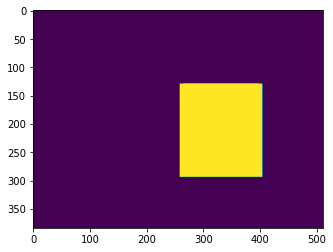

In [32]:
# Display the corresponding mask

masks_list = os.listdir('masks_512_dir')

path = 'masks_512_dir/' + df_data.loc[item, 'Image_ID'] + '.JPG'

mask = plt.imread(path)

print(mask.shape)

plt.imshow(mask)
plt.show()

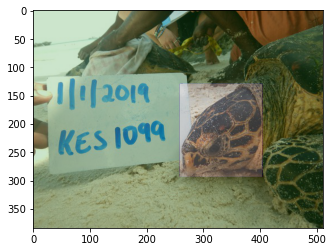

In [33]:
# Overlay the image and mask

plt.imshow(image)
plt.imshow(mask, cmap='ocean', alpha=0.2)
plt.show()

## Set up image augmentation

In [34]:
# The turtle heads are close to the center in every image.
# Because of this the model will try to be lazy smart and mimimize it's loss 
# by simply predicting a standard size box in the same location for all images.

# To solve this problem we will use augmentation to shift the turtle heads.

In [35]:
import albumentations as albu

# Define the augmentations

def get_training_augmentation():
    
    train_transform = [
    albu.HorizontalFlip(always_apply=False, p=0.5),
    albu.ShiftScaleRotate (shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, 
                           always_apply=False, p=0.6),
    albu.Blur(blur_limit=7, always_apply=False, p=0.3),
    albu.OneOf([
        albu.RandomContrast(),
        albu.RandomGamma(),
        #albu.RandomBrightness(), #### This is creating an error
        ], p=0.5),
    albu.OneOf([
        albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        albu.GridDistortion(),
        albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.5),
   
    ]
  
    return albu.Compose(train_transform)



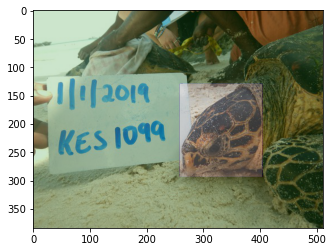

In [36]:
# Load an image and mask

item = 7

# Load an image
path = image_path + df_data.loc[item, 'Image_ID'] + '.JPG'
image = plt.imread(path)

# Load the mask
path = 'masks_512_dir/' + df_data.loc[item, 'Image_ID'] + '.JPG'
mask = plt.imread(path)


plt.imshow(image)
plt.imshow(mask, cmap='ocean', alpha=0.2)
plt.show()

0
241
(384, 512, 3)
(384, 512)


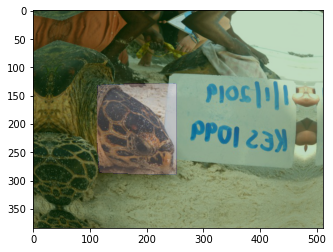

In [37]:
# Display an AUGMENTED image

augmentation = get_training_augmentation()

# The beauty of albumentations is that the same augmentation
# is applied both to the image and to its mask.
sample = augmentation(image=image, mask=mask)
image, mask = sample['image'], sample['mask']


print(image.min())
print(image.max())

print(image.shape)
print(mask.shape)



plt.imshow(image)
plt.imshow(mask, cmap='ocean', alpha=0.2)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-2.1179039301310043
2.3959912854030496
(384, 512, 3)
(384, 512)


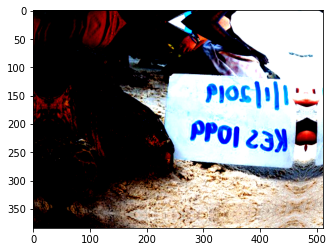

In [38]:
# Display a PRE-PROCESSED image

from segmentation_models_pytorch.encoders import get_preprocessing_fn

# Initialize the preprocessing function
preprocessing_fn = get_preprocessing_fn(BACKBONE, pretrained='imagenet')

preprocessing = get_preprocessing(preprocessing_fn)

sample = preprocessing(image=image, mask=mask)
image, mask = sample['image'], sample['mask']

print(image.min())
print(image.max())

print(image.shape)
print(mask.shape)


plt.imshow(image)
plt.show()

## Create the folds

In [39]:
# We will create 5 folds and stratify by image height.
# There are two different image heights in the dataset.
# We will train only using one of the 5 folds in the same
# way as one would do when using train_test_split.

In [40]:
from sklearn.model_selection import KFold, StratifiedKFold

# shuffle
df = shuffle(df_data)

# initialize kfold
kf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=1024)

# for stratification
y = df['height']

# Note:
# Each fold is a tuple ([train_index_values], [val_index_values])
# fold_0, fold_1, fold_2, fold_3, fold_5 = kf.split(df, y)

# Put the folds into a list. This is a list of tuples.
fold_list = list(kf.split(df, y))

train_df_list = []
val_df_list = []

for i, fold in enumerate(fold_list):

    # map the train and val index values to dataframe rows
    df_train = df[df.index.isin(fold[0])]
    df_val = df[df.index.isin(fold[1])]
    
    train_df_list.append(df_train)
    val_df_list.append(df_val)
    

print(len(train_df_list))
print(len(val_df_list))

5
5


## Create the dataloader

In [41]:
df_data.head()

Image_ID         x         y         w         h  height  width
0  04FB1B33  0.481988  0.506076  0.174696  0.405671     384    512
1  B04E481E  0.617405  0.313368  0.177734  0.293113     384    512
2  32655645  0.490885  0.465856  0.165582  0.357350     384    512
3  44D4DA7C  0.472873  0.506076  0.237847  0.409722     384    512
4  4F36EF72  0.433811  0.574363  0.180773  0.397569     384    512

In [47]:
class CompDataset(Dataset):
    
    def __init__(self, df, augmentation=None, preprocessing=None):
        self.df = df
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __len__(self):
        return len(self.df)
        
        
        
    def __getitem__(self, index):
            
        #base_path = '../input/zindi-sea-turtles/'
        image_path = base_path + 'IMAGES_512/IMAGES_512/'
        
        image_id =  self.df.loc[index, 'Image_ID']

        # set the path to the image
        path = image_path + image_id + '.JPG'
        
        # Create the image
        # ------------------

        # read the image
        image = cv2.imread(path)
        
        # read the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # resize the image
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        
        # create a channel dimension
        #image = np.expand_dims(image, axis=-1)
        
        
        
        # Create the mask
        # ------------------
        
        # create the mask
        path = 'masks_512_dir/' + image_id + '.JPG'
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        # resize the mask
        mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
        
        # create a channel dimension
        mask = np.expand_dims(mask, axis=-1)
        
  
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            

    
        # Swap color axis
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        mask = mask.transpose((2, 0, 1))
        
        # convert to torch tensor
        image = torch.tensor(image, dtype=torch.float)
        mask = torch.tensor(mask, dtype=torch.float)
        
        
        
        return {
                "images": image,
                "masks": mask
                }
    
    

In [48]:
class TestDataset(Dataset):
    
    def __init__(self, df, preprocessing=None):
        self.df = df
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.df)
        
        
        
    def __getitem__(self, index):
            
        #base_path = '../input/zindi-sea-turtles/'
        image_path = base_path + 'IMAGES_512/IMAGES_512/'
        
        image_id = self.df.loc[index, 'Image_ID']


        # set the path to the image
        path = image_path + image_id  + '.JPG'
        
        # Create the image
        # ------------------

        # read the image
        image = cv2.imread(path)
        
        # read the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # resize the image
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, _ = sample['image'], sample['mask']
    
        # Swap color axis
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        # convert to torch tensor
        image = torch.tensor(image, dtype=torch.float)
        
        
        
        return {
                "images": image
                }
    

## Test the dataloader

In [49]:
# Intialize the fold dataframes
fold_index = 0

df_train = train_df_list[fold_index]
df_val = val_df_list[fold_index]

In [50]:
# Reset the indices.
# If the dataloder returns an error during training
# it's usually because the indices of the input dataframe
# have not been reset.
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [51]:
from segmentation_models_pytorch.encoders import get_preprocessing_fn

# Initialize the preprocessing function
preprocessing_fn = get_preprocessing_fn(BACKBONE, pretrained='imagenet')

# Create the dataloders.
# This is just an example.
# We will initialize the dataloaders again later.

train_data = CompDataset(df_train, augmentation=None,
                         preprocessing=get_preprocessing(preprocessing_fn))

val_data = CompDataset(df_val, augmentation=None,
                      preprocessing=get_preprocessing(preprocessing_fn))



train_dataloader = torch.utils.data.DataLoader(train_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                       num_workers=NUM_CORES)

val_dataloader = torch.utils.data.DataLoader(val_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                       num_workers=NUM_CORES)



print(len(train_dataloader))
print(len(val_dataloader))

133
34


In [52]:
# Get one train batch

data = next(iter(train_dataloader))

print(data['images'].shape)
print(data['masks'].shape)

torch.Size([8, 3, 256, 256])
torch.Size([8, 1, 256, 256])


In [53]:
images = data['images']

image = images[7]

# convert from (C, H, W) to (H, W, C) format
image = image.permute((1, 2, 0))

image = image[:, :, 0]

print(image.shape)

plt.imshow(image, cmap='bone')

plt.show()

torch.Size([256, 256])


In [54]:
masks = data['masks']

mask = masks[7]

print(mask.shape)

# convert from (C, H, W) to (H, W, C) format
mask = mask.permute((1, 2, 0))

mask = mask[:, :, 0]

print(mask.shape)

plt.imshow(mask, cmap='bone')

plt.show()

torch.Size([1, 256, 256])
torch.Size([256, 256])


In [55]:
plt.imshow(image)
plt.imshow(mask, cmap='ocean', alpha=0.2)
plt.show()

In [56]:
# Get one val batch

data = next(iter(val_dataloader))

print(data['images'].shape)
print(data['masks'].shape)

torch.Size([8, 3, 256, 256])
torch.Size([8, 1, 256, 256])


In [57]:
# Display the image batch in a grid

grid = torchvision.utils.make_grid(images) # nrows is the number of classes

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


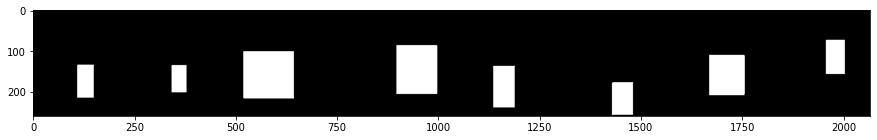

In [58]:
# Display the mask batch in a grid

grid = torchvision.utils.make_grid(masks) # nrows is the number of classes

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.show()

## Define the Model

In [59]:
# This is just an example to help us test that everything works.
# We will define the model again later inside the model_fn().

In [60]:
# (1) Segmentation Model
# .......................

# seg_model Input: 
# 3x256x256 RGB pre-processed image

# seg_model Output:
# Mask with float values in range 0 to 1


ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' 

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=BACKBONE, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(BACKBONE, ENCODER_WEIGHTS)

# print(model)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


## Test the model

In [61]:
# Create an input batch

data = next(iter(train_dataloader))

print(data['images'].shape)
print(data['masks'].shape)

torch.Size([8, 3, 256, 256])
torch.Size([8, 1, 256, 256])


In [62]:
model.eval()

images = data['images']
targets = data['masks']

# pass the images into the model
outputs = model(images)


print(outputs.shape)
print(targets.shape)

torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])


In [63]:
outputs[0]

tensor([[[0.5071, 0.4881, 0.4874,  ..., 0.5815, 0.5274, 0.5580],
         [0.5137, 0.4866, 0.4837,  ..., 0.6164, 0.6310, 0.6706],
         [0.5139, 0.5223, 0.4860,  ..., 0.6359, 0.6629, 0.6824],
         ...,
         [0.5274, 0.5844, 0.5811,  ..., 0.7622, 0.7587, 0.7147],
         [0.5258, 0.5413, 0.5554,  ..., 0.6142, 0.6728, 0.6436],
         [0.5126, 0.5244, 0.5620,  ..., 0.5887, 0.6627, 0.5941]]],
       grad_fn=<SelectBackward>)

In [64]:
targets[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [65]:
# Calculate the loss

def loss_fn(outputs, targets):
    
    loss = smp.utils.losses.DiceLoss()
    output = loss(outputs, targets)

    return output

loss = loss_fn(outputs, targets)

loss.item()

0.8028571605682373

# Engine - Training and Evaluation

In [66]:
# Define the loss

def loss_fn(outputs, targets):
    
    loss = smp.utils.losses.DiceLoss()
    output = loss(outputs, targets)

    return output


In [67]:
# Define the metric

def calculate_iou(y_true, y_pred):
    
    """
    Input: Numpy arrays with shape (image_h, image_w)
    Output: IOU value as a number.
    
    This works only for single images and not
    for a batch of images.
    """
    
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    result = (y_true_flat * y_pred_flat)

    area_of_intersection = np.sum(result)

    area_of_union = (np.sum(y_true_flat) + np.sum(y_pred_flat)) - area_of_intersection
    
    # add 0.00001 to prevent a zero division error.
    IOU = (area_of_intersection)/(area_of_union + 0.00001)
    
    return IOU



def metric_fn(df, outputs, targets):

    torch_outputs = torch.tensor(outputs)
    torch_targets = torch.tensor(targets)

    # This is for when the sigmoid activation
    # is not part of a model and has to be done separately.
    #sigmoid = torch.nn.Sigmoid()
    #pred_probas = sigmoid(torch_outputs)
    
    targets = torch_targets.detach().numpy()
    pred_probas = torch_outputs.detach().numpy()
    
    # Threshold the predictions
    thresh_preds = (pred_probas >= 0.5).astype(np.uint8)
    
    score_list = []

    for index in range(0, len(df_val)):

        path = image_path + df.loc[index, 'Image_ID'] + '.JPG'
        image = plt.imread(path)

        path = 'masks_512_dir/' + df.loc[index, 'Image_ID'] + '.JPG'
        true_mask = plt.imread(path)

        true_mask = cv2.resize(true_mask, (image.shape[1], image.shape[0]))

        # add the bbox mask to the blank mask created above
        pred_mask = thresh_preds[index]

        pred_mask = pred_mask.squeeze()

        pred_mask = cv2.resize(pred_mask, (image.shape[1], image.shape[0]))

        iou = calculate_iou(pred_mask, true_mask)

        score_list.append(iou)
    
    return np.mean(score_list)

In [68]:
# Define the train function


def train_fn(df, model, optimizer, device, scheduler):

    data = CompDataset(df, augmentation=get_training_augmentation(), 
                       preprocessing=get_preprocessing(preprocessing_fn))
    #data = CompDataset(df, augmentation=get_training_augmentation())

    data_loader = torch.utils.data.DataLoader(data,
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                           num_workers=NUM_CORES)
    
    model.train()
    
    # This turns gradient calculations on and off.
    torch.set_grad_enabled(True)
    
    fin_targets = []
    

    for i, data in tq.tqdm(enumerate(data_loader), total=len(data_loader)):
        
        images = data['images']
        targets = data['masks']


        images = images.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)

        optimizer.zero_grad()
        
        outputs = model(images)
        

        loss = loss_fn(outputs, targets)
        loss.backward()
        
        optimizer.step()
      
        scheduler.step()
        

        # convert to numpy so we can stack the batches.
        outputs = outputs.cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        
        # stack the preds and targets from each batch
        if i == 0:
            fin_outputs = outputs
            fin_targets = targets
        else:
            fin_outputs = np.vstack((fin_outputs, outputs))
            fin_targets = np.vstack((fin_targets, targets))
            
        
        
    return fin_outputs, fin_targets
            

In [69]:
# Define the val function

def eval_fn(df, model, device):
    
    data = CompDataset(df, augmentation=None, 
                       preprocessing=get_preprocessing(preprocessing_fn))

    data_loader = torch.utils.data.DataLoader(data,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False,
                                           num_workers=1)
    
    model.eval()
    
    # This turns gradient calculations on and off.
    torch.set_grad_enabled(False)
    
    fin_targets = []
    

    for i, data in tq.tqdm(enumerate(data_loader), total=len(data_loader)):
        
        images = data['images']
        targets = data['masks']


        images = images.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)


        outputs = model(images)
        
        # convert to numpy so we can stack the batches.
        outputs = outputs.cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        
        # stack the preds from each batch
        # stack the preds and targets from each batch
        if i == 0:
            fin_outputs = outputs
            fin_targets = targets
        else:
            fin_outputs = np.vstack((fin_outputs, outputs))
            fin_targets = np.vstack((fin_targets, targets))
        

    return fin_outputs, fin_targets

In [70]:
# Define the inference function

def inference_fn(df, model, device):
    
    data = TestDataset(df,
                       preprocessing=get_preprocessing(preprocessing_fn))

    data_loader = torch.utils.data.DataLoader(data,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False,
                                           num_workers=1)
    
    model.eval()
    
    # This turns gradient calculations on and off.
    torch.set_grad_enabled(False)

    

    for i, data in tq.tqdm(enumerate(data_loader), total=len(data_loader)):
        
        images = data['images']

        images = images.to(device, dtype=torch.float)


        outputs = model(images)
        
        # convert to numpy so we can stack the batches.
        outputs = outputs.cpu().detach().numpy()
        
        # stack the preds from each batch
        if i == 0:
            fin_outputs = outputs
        else:
            fin_outputs = np.vstack((fin_outputs, outputs))
        
        

    return fin_outputs

In [71]:
# Define the model, optimizer and scheduler

def model_fn(df_train): 
        
    ENCODER_WEIGHTS = 'imagenet'
    ACTIVATION = 'sigmoid' 

    # create segmentation model with pretrained encoder
    model = smp.Unet(
        encoder_name=BACKBONE, 
        encoder_weights=ENCODER_WEIGHTS, 
        classes=1, 
        activation=ACTIVATION
        )


    num_train_steps = int(len(df_train) / BATCH_SIZE * NUM_EPOCHS)

    optimizer = torch.optim.Adam(model.parameters(), lr=L_RATE)
  
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=num_train_steps)

        
    return model, optimizer, scheduler

## Training

In [72]:
# This setup is designed for 5 fold cross validation but
# here we will only train on one fold.

fold_train_scores_list = []
fold_val_scores_list = []
val_preds_list = []
val_targets_list = []
test_preds_list = []



# reset the index
df_test = df_test.reset_index(drop=True)


# For each fold...
for fold_index in range(0, NUM_FOLDS_TO_TRAIN):

    print('\n== Fold Model', fold_index)
    

    # Get df_train and df_val
    # ........................

    # Intialize the fold dataframes
    df_train = train_df_list[fold_index]
    df_val = val_df_list[fold_index]
    

    # Reset the indices or the dataloader won't work.
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)

    
    model, optimizer, scheduler = model_fn(df_train)
    model.to(device)
    


    # Training for the specified number of epochs
    # ............................................
    
    best_score = 0 # best IOU score is 1.0
    early_stopping_count = 0
    
    for epoch in range(0, NUM_EPOCHS):  

        # Train the model.
        train_outputs, train_targets = train_fn(df_train, model, optimizer, device, scheduler)

        # Use the trained model to predict on the val set.
        # Generate a dictionary of outputs.
        val_outputs, val_targets = eval_fn(df_val, model, device)


        print('Epoch', epoch)

        # Calculate the train score

        score = metric_fn(df_train, train_outputs, train_targets)

        print(f"Train avg IOU Score = {score}")


        # Calculate the val score

        score = metric_fn(df_val, val_outputs, val_targets)

        print(f"Val avg IOU Score = {score}")


        # Save the model
        
        path_model = str(fold_index) + '_model.bin'

        if epoch == 0:
            torch.save(model.state_dict(), path_model)
            print('Model saved:', path_model)
            
            early_stopping_count = 0

        if score > best_score:
            torch.save(model.state_dict(), path_model)
            print('Val score improved. Model saved:', path_model)
            best_score = score
            
            early_stopping_count = 0
            
        else:
            early_stopping_count = early_stopping_count + 1
        
        if early_stopping_count > PATIENCE:
            # Stop the loop.
            # Move to the next fold when doing cross validaton.
            print('\n *** Early stopping. ***')
            break
        
        print('\n')



== Fold Model 0



Epoch 0
Train avg IOU Score = 0.17007069470441555
Val avg IOU Score = 0.6667941892508187
Model saved: 0_model.bin
Val score improved. Model saved: 0_model.bin





Epoch 1
Train avg IOU Score = 0.22544732439309983
Val avg IOU Score = 0.7412922274179804
Val score improved. Model saved: 0_model.bin





Epoch 2
Train avg IOU Score = 0.21008819067352394
Val avg IOU Score = 0.7348187110843039





Epoch 3
Train avg IOU Score = 0.20803573197692424
Val avg IOU Score = 0.8040562945142065
Val score improved. Model saved: 0_model.bin





Epoch 4
Train avg IOU Score = 0.20455376040516263
Val avg IOU Score = 0.8147379933561761
Val score improved. Model saved: 0_model.bin





Epoch 5
Train avg IOU Score = 0.20291708040113293
Val avg IOU Score = 0.8122852562388648





Epoch 6
Train avg IOU Score = 0.2150723015958335
Val avg IOU Score = 0.8120546367448053





Epoch 7
Train avg IOU Score = 0.20291630575642472
Val avg IOU Score = 0.8198614645340123
Val score improved. Model saved: 0_model.bin





Epoch 8
Train avg IOU Score = 0.19351685817437253
Val avg IOU Score = 0.8239044843721091
Val score improved. Model saved: 0_model.bin





Epoch 9
Train avg IOU Score = 0.19785159612931277
Val avg IOU Score = 0.8235755878168836





Epoch 10
Train avg IOU Score = 0.19453480612073026
Val avg IOU Score = 0.8280029751958806
Val score improved. Model saved: 0_model.bin





Epoch 11
Train avg IOU Score = 0.203632041495569
Val avg IOU Score = 0.8343135609800312
Val score improved. Model saved: 0_model.bin





Epoch 12
Train avg IOU Score = 0.19848246027827476
Val avg IOU Score = 0.8367573471836747
Val score improved. Model saved: 0_model.bin





Epoch 13
Train avg IOU Score = 0.21844171698363637
Val avg IOU Score = 0.8422188825733087
Val score improved. Model saved: 0_model.bin





Epoch 14
Train avg IOU Score = 0.2077410133889339
Val avg IOU Score = 0.8319226430590002





Epoch 15
Train avg IOU Score = 0.19506371336349188
Val avg IOU Score = 0.8390743336813091





Epoch 16
Train avg IOU Score = 0.18050239711817886
Val avg IOU Score = 0.8411846671891744





Epoch 17
Train avg IOU Score = 0.1803299279767753
Val avg IOU Score = 0.8424389937402225
Val score improved. Model saved: 0_model.bin





Epoch 18
Train avg IOU Score = 0.19676820801026992
Val avg IOU Score = 0.8454627521848154
Val score improved. Model saved: 0_model.bin





Epoch 19
Train avg IOU Score = 0.20557442253945415
Val avg IOU Score = 0.848073617864713
Val score improved. Model saved: 0_model.bin





Epoch 20
Train avg IOU Score = 0.22242230097981475
Val avg IOU Score = 0.843446355863336





Epoch 21
Train avg IOU Score = 0.20670840311301913
Val avg IOU Score = 0.8481725537360365
Val score improved. Model saved: 0_model.bin





Epoch 22
Train avg IOU Score = 0.19991200357880248
Val avg IOU Score = 0.8504690093327947
Val score improved. Model saved: 0_model.bin





Epoch 23
Train avg IOU Score = 0.2052606092183651
Val avg IOU Score = 0.8507138674448432
Val score improved. Model saved: 0_model.bin





Epoch 24
Train avg IOU Score = 0.20395964899634542
Val avg IOU Score = 0.8539428168926873
Val score improved. Model saved: 0_model.bin





Epoch 25
Train avg IOU Score = 0.19933247516584576
Val avg IOU Score = 0.8530239913205379





Epoch 26
Train avg IOU Score = 0.2093007031125808
Val avg IOU Score = 0.8527684233449342





Epoch 27
Train avg IOU Score = 0.20356511128341812
Val avg IOU Score = 0.8546053994844003
Val score improved. Model saved: 0_model.bin





Epoch 28
Train avg IOU Score = 0.21222451669799272
Val avg IOU Score = 0.8535349922153869





Epoch 29
Train avg IOU Score = 0.18830625684761088
Val avg IOU Score = 0.8557448393378159
Val score improved. Model saved: 0_model.bin




## Load the best model

In [ ]:
path_model = '0_model.bin'

model.load_state_dict(torch.load(path_model))
model.to(device)

## Make a prediction on the val set

In [74]:
val_preds = inference_fn(df_val, model, device)

val_preds.shape

(266, 1, 256, 256)

In [75]:
# Threshold the predictions so that
# all values are either 0 or 1.

# Threshold the predictions
thresh_preds = (val_preds >= 0.5).astype(np.uint8)

thresh_preds.shape

(266, 1, 256, 256)

In [76]:
print(thresh_preds.min())
print(thresh_preds.max())

0
1


In [77]:
score_list = []

for index in range(0, len(df_val)):
    
    path = image_path + df_val.loc[index, 'Image_ID'] + '.JPG'
    image = plt.imread(path)
    
    path = 'masks_512_dir/' + df_val.loc[index, 'Image_ID'] + '.JPG'
    true_mask = plt.imread(path)
    
    true_mask = cv2.resize(true_mask, (256, 256))

    # add the bbox mask to the blank mask created above
    pred_mask = thresh_preds[index]
    
    pred_mask = pred_mask.squeeze()
    
    pred_mask = pred_mask.astype('int')
    true_mask = true_mask.astype('int')
    
    jac = calculate_iou(pred_mask, true_mask)
    
    score_list.append(jac)
    
# add the iou scores for each image to the val dataframe.   
df_val['thresh_iou_score'] = score_list

df_val.head()

Image_ID         x         y  ...  height  width  thresh_iou_score
0  2200EA3A  0.471354  0.147569  ...     384    512          0.770126
1  C3D2C3FA  0.454750  0.221667  ...     384    512          0.892492
2  C85C5669  0.240757  0.347418  ...     384    512          0.830281
3  B29A6B5A  0.371528  0.447421  ...     384    512          0.889734
4  F19F7276  0.227500  0.602333  ...     384    512          0.777288

[5 rows x 8 columns]

In [78]:
# Get a quick overview of the model's val performance

mean_val_iou = df_val['thresh_iou_score'].mean()
min_val_iou = df_val['thresh_iou_score'].min()
max_val_iou = df_val['thresh_iou_score'].max()

print('Mean val iou:', mean_val_iou)
print('Min val iou:', min_val_iou)
print('Max val iou:', max_val_iou)

Mean val iou: 0.8552398358233866
Min val iou: 0.6056470559734256
Max val iou: 0.9474690795008682


In [95]:
# Save the val dataframe as a compressed csv file.
# The compressed format is useful when saving 
# big dataframes that use a lot of disk memory.
# Saving will allow us to analyze the val iou results later
# in another notebook without having to train the model again.

path = '/content/gdrive/My Drive/' + 'path_to_your_drive_folder' + '/df_val.csv.gz'

df_val.to_csv(path, compression='gzip', index=False)

# This is how to load this saved dataframe.
# No need to uncompress it. Pandas can read compressed csv files.
# df_val = pd.read_csv('df_val.csv.gz')

In [80]:
# Display the raw val predictions.

# You will note that even tho we gave the model a
# bounding box mask as a target it still produced an output
# that's close to being a segmentation. Althouth far from perfect, the model has
# learned to follow the contours of a turtles head.
# This is a magic ability that Unet has that I've
# also seen on past projects.


# Later we will use sklearn connected components to
# convert these segmentations into bounding boxes
# for the competition submission.

display_preds(df_val, thresh_preds)

## Make a prediction on the test set

In [81]:
test_preds = inference_fn(df_test, model, device)

test_preds.shape

(695, 1, 256, 256)

In [82]:
test_preds.max()

1.0

In [83]:
# Threshold the raw predictions

# Threshold the predictions
thresh_preds = (test_preds >= 0.5).astype(np.uint8)

thresh_preds.shape

(695, 1, 256, 256)

In [84]:
# Display the predictions

display_preds(df_test, thresh_preds)

## Convert the test preds into bounding boxes

In [85]:
path = base_path + 'SampleSubmission.csv'
df_sample= pd.read_csv(path)

print(df_sample.shape)

df_sample.head()

(695, 5)


Image_ID  x  y  w  h
0  4863D911  0  0  0  0
1  6DD3ADD5  0  0  0  0
2  E8DC4D6A  0  0  0  0
3  E02ABB6C  0  0  0  0
4  875C19F4  0  0  0  0

In [86]:
thresh_preds.shape

(695, 1, 256, 256)

In [87]:
x_list = []
y_list = []
h_list = []
w_list = []

for i in range(0, len(df_test)):
    
    # Convert the predicted masks into bounding boxes and
    # get the bbox coordinates.
    data = convert_seg_to_bbox(df_test, i)
    
    # get the percent coords
    x, y, h, w = data['percent_coords']
    
    x_list.append(x)
    y_list.append(y)
    h_list.append(h)
    w_list.append(w)
    
    
    
# Add the percent coords to df_sample

df_sample['x'] = x_list
df_sample['y'] = y_list
df_sample['h'] = h_list
df_sample['w'] = w_list

print(df_sample.shape)

df_sample.head()

(695, 5)


Image_ID     x     y     w     h
0  4863D911  0.16  0.22  0.61  0.62
1  6DD3ADD5  0.33  0.29  0.39  0.50
2  E8DC4D6A  0.35  0.52  0.46  0.45
3  E02ABB6C  0.32  0.52  0.46  0.42
4  875C19F4  0.36  0.43  0.44  0.43

## Create a submission csv file

In [94]:
# Create a submission csv file
path = '/content/gdrive/My Drive/' + 'path_to_your_drive_folder' + '/submission.csv'
df_sample.to_csv(path, index=False)

In [89]:
# Create a requirements.txt file

!pip freeze > requirements.txt

In [90]:
!ls

0_model.bin    gdrive  masks_512_dir	 sample_data
df_val.csv.gz  input   requirements.txt


In [90]:
# Save the trained model to your google drive

path_model = '/content/gdrive/My Drive/' + 'path_to_your_drive_folder' + '/0_model.bin'

torch.save(model.state_dict(), path_model)
print('Model saved:', path_model)

In [92]:
# This step is useful when committing this notebook on Kaggle.
# Delete the masks directory to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

# Uncomment these two lines line before committing this notebook on Kaggle.
#if os.path.isdir('masks_512_dir') == True:
    #shutil.rmtree('masks_512_dir')

## References and Resources

- Notebook by Jonne where I first saw the segmentation plus connected components approach used: <br>
https://www.kaggle.com/jonnedtc/cnn-segmentation-connected-components

- Video on the encoder decoder network architecture, by Computerphile:<br>
https://www.youtube.com/watch?v=1icvxbAoPWc

- Segmentation models package by qubvel:<br>
https://github.com/qubvel/segmentation_models.pytorch

- Notes on using the segmentation models package by Chris Deotte: <br>
https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/103367#latest-595453

- Basic image techniques by vbookshelf: <br>
https://www.kaggle.com/vbookshelf/how-to-generate-artificial-cell-images

- Video tutorial series to learn Pytorch, by deeplizard:<br>
https://deeplizard.com/learn/video/v5cngxo4mIg

- U-Net Paper<br>
U-Net: Convolutional Networks for Biomedical Image Segmentation<br>
https://arxiv.org/abs/1505.04597

- MobileNet paper<br>
MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications<br>
https://arxiv.org/abs/1704.04861

- IOU metric explanation:<br>
https://medium.com/datadriveninvestor/deep-learning-in-medical-imaging-3c1008431aaf